In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time, random

In [2]:
class Parameter:
    "mini-batch Gradient Descent parameters"

    def __init__(self, n_batch, eta, n_epochs):
        self.n_batch = n_batch
        self.eta = eta
        self.n_epochs = n_epochs

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
# 1.
def loadBatch(filename):
    cifar = unpickle(filename)

    X = cifar[b'data'].T/255.0  # numpy array of size dxN    
    y = np.array(cifar[b'labels'])  # vector of lables of size 1xN
    Y = np.zeros((10,X.shape[1]))  # matrix of KxN
    Y[y,np.arange(len(y))] = 1

    return X,Y,y

In [5]:
# 3.
def evaluateClassifier(X,W,b):
    s = np.dot(W,X) + b
    p = np.exp(s)/np.expand_dims(np.exp(s).sum(axis=0),axis=0)  # matrix of size KxN
    return p

In [6]:
# 4.
def computeCost(X,Y,W,b,lamb):
    P = evaluateClassifier(X,W,b)
    J = np.sum(-np.log(np.diag(np.dot(Y.T,P))))/(X.shape[1]+0.0) + lamb*np.sum(W*W)
    return J

In [7]:
# 5.
def computeAccuracy(X,y,W,b):
    P = evaluateClassifier(X,W,b)
    y_pred = np.argmax(P, axis=0)
    acc = np.sum(y==y_pred)/(len(y)+0.0)
    return acc

In [8]:
# 6.
def computeGradients(X,Y,P,W,lamb):
    N = X.shape[1]
    
    g = P-Y
    grad_b = np.expand_dims(g.sum(axis=1),axis=1)/(N+0.0)
    grad_W = np.dot(g,X.T)/(N+0.0) + 2*lamb*W
               
    return grad_W, grad_b

In [9]:
# convert matlab function in construction
def computeGradsNum(X, Y, W, b, lamb, h):
    no = W.shape[0]
    d = X.shape[0]

    grad_W = np.zeros(W.shape)
    grad_b = np.zeros((no, 1))

    c = computeCost(X, Y, W, b, lamb)

    for i in range(len(b)):
        b_try = b.copy()
        b_try[i] = b_try[i] + h
        c2 = computeCost(X, Y, W, b_try, lamb)
        grad_b[i] = (c2-c)/h
        

    for i in range(no):
        for j in range(d):
            W_try = W.copy()
            W_try[i,j] = W_try[i,j] + h
            c2 = computeCost(X, Y, W_try, b, lamb)
    
            grad_W[i,j] = (c2-c) / h
    return grad_W, grad_b

In [10]:
# convert matlab function in construction
def computeGradsNumSlow(X, Y, W, b, lamb, h):
    no = W.shape[0]
    d = X.shape[0]

    grad_W = np.zeros(W.shape)
    grad_b = np.zeros((no, 1))

    for i in range(len(b)):
        b_try = b.copy()
        b_try[i] = b_try[i] - h
        c1 = computeCost(X, Y, W, b_try, lamb)
        b_try = b.copy()
        b_try[i] = b_try[i] + h
        c2 = computeCost(X, Y, W, b_try, lamb)
        grad_b[i] = (c2-c1)/(2*h)

    for i in range(no):
        for j in range(d):
            W_try = W.copy()
            W_try[i,j] = W_try[i,j] - h
            c1 = computeCost(X, Y, W_try, b, lamb)
            W_try = W.copy()
            W_try[i,j] = W_try[i,j] + h
            c2 = computeCost(X, Y, W_try, b, lamb)
    
            grad_W[i,j] = (c2-c1)/(2*h)
    return grad_W, grad_b

In [11]:
def miniBatchGD(X,Y,y,GDparams,W,b,lamb,arg_par='0'):
    X_train = X[0]
    Y_train = Y[0]
    y_train = y[0]
    X_val = X[1]
    Y_val = Y[1]
    y_val = y[1]
    
    d,N = X_train.shape
    numBatches = int(N/GDparams.n_batch)
    
    # randomly initialize the weights and the thresholds
    W_star = W
    b_star = b
    
    loss_train = np.zeros(GDparams.n_epochs)   
    loss_val = np.zeros(GDparams.n_epochs)
    error_train = np.zeros(GDparams.n_epochs)   
    error_val = np.zeros(GDparams.n_epochs)
    
    XBatch,YBatch = generateBatches(X_train,Y_train,GDparams.n_batch)
    
    for i in range(GDparams.n_epochs):
        for j in range(numBatches):
            xTr = XBatch[:,:,j]
            yTr = YBatch[:,:,j]            
            P = evaluateClassifier(xTr,W_star,b_star)
            grad_w,grad_b = computeGradients(xTr,yTr,P,W_star,lamb)
            # update the weights and the thresholds
            W_star = W_star - GDparams.eta*grad_w
            b_star = b_star - GDparams.eta*grad_b
            
        loss_train[i] = computeCost(X_train,Y_train,W_star,b_star,lamb)        
        loss_val[i] = computeCost(X_val,Y_val,W_star,b_star,lamb)
        
        error_train[i] = 1-computeAccuracy(X_train,y_train,W_star,b_star)
        error_val[i] = 1-computeAccuracy(X_val,y_val,W_star,b_star)
        
    plotResults(range(GDparams.n_epochs),[loss_train, loss_val],'loss',arg_par)
    plotResults(range(GDparams.n_epochs),[error_train, error_val],'error',arg_par)
    
    return W_star,b_star

def generateBatches(X,Y,n_batch):
    d,N = X.shape
    K = Y.shape[0]
    XBatch = np.zeros((d,n_batch,int(N/n_batch)))
    YBatch = np.zeros((K,n_batch,int(N/n_batch)))
    
    for i in range(int(N/n_batch)):
        i_start = i*n_batch
        i_end = (i+1)*n_batch
        XBatch[:,:,i] = X[:,i_start:i_end]
        YBatch[:,:,i] = Y[:,i_start:i_end]
    return XBatch, YBatch

def plotResults(x,y,name='loss',par='0'):
    fig = plt.figure()
    plt.plot(x,y[0],label='training '+name)
    plt.plot(x,y[1],label='validation '+name)
    plt.legend(loc=0)
    plt.xlabel('n_epochs')
    plt.ylabel(name)
    fig.savefig('Figures/'+name+'_params'+par+'.pdf')
    plt.show()

In [16]:
# Check gradient computation
def checkGrads(X, Y, W, b, lamb, h=1e-6):
    eps = 1e-15
    error = 1e-6
    
    gW1,gb1 = computeGradsNumSlow(X, Y, W, b, lamb, h)
    P = evaluateClassifier(X,W,b)
    gW2,gb2 = computeGradients(X,Y,P,W,lamb)
    
    error_w = np.abs(gW1-gW2)/np.maximum(eps,np.abs(gW1)+np.abs(gW2))
    error_b = np.abs(gb1-gb2)/np.maximum(eps,np.abs(gb1)+np.abs(gb2))
    print('The number of error (relative error > 1e-6) of W:', np.sum(error_w>error))
    print('The maximum of relative error of W:', np.max(error_w))
    print('The number of error (relative error > 1e-6) of b:', np.sum(error_b>error))
    print('The maximum of relative error of b:', np.max(error_b))

In [13]:
# Plot W
def plotW(W,class_name,arg_par='0'):
    fig=plt.figure(figsize=(20,2))
    for i in range(10):
        im = W[i,:].reshape(3,32,32)
        img = np.transpose((im-np.min(im))/(np.max(im)-np.min(im)),(1,2,0))
        plt.subplot(1, 10, i+1)                 
        plt.title(class_name[i])
        plt.imshow(img)
        plt.axis('off')
                       
    plt.savefig('Figures/imW_params'+arg_par+'.pdf')
    plt.show()

In [28]:
# Load data
XTr,YTr,yTr = loadBatch('cifar-10-batches-py/data_batch_1')  # Training set
XVa,YVa,yVa = loadBatch('cifar-10-batches-py/data_batch_2')  # Validation set
XTe,YTe,yTe = loadBatch('cifar-10-batches-py/test_batch')    # Test set
names = unpickle("cifar-10-batches-py/batches.meta")[b'label_names']  # list if size (10,1)

K = len(names)
d = XTr.shape[1]
class_name = []
for i in range(K):
    class_name.append(names[i].decode("utf-8"))

In [29]:
#Initialize the parameters W and b
W = np.random.randn(K,d) * 0.01
b = np.random.randn(K,1) * 0.01

In [26]:
# Check evaluateClassifier function
P = evaluateClassifier(XTr[:,:100], W, b)
print(P.shape)

(10, 100)


In [17]:
# Check gradient computation
lamb = 0.1
X = XTr[:,:100]
Y = YTr[:,:100]

checkGrads(X, Y, W, b, lamb)

The number of error (relative error > 1e-6) of W: 83
The maximum of relative error of W: 2.3180494388577465e-05
The number of error (relative error > 1e-6) of b: 0
The maximum of relative error of b: 9.296465219806587e-09


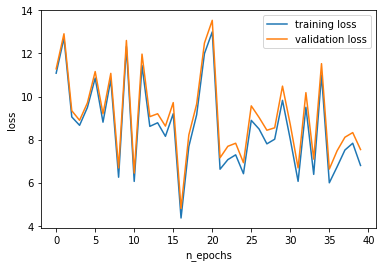

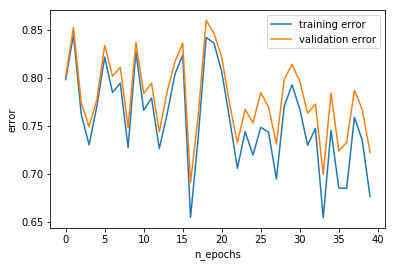

The accuracy on test set:  28.28 %


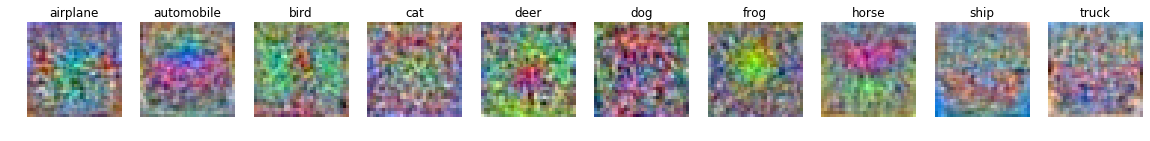

In [18]:
# Plot loss function
X = [XTr, XVa]
Y = [YTr, YVa]
y = [yTr, yVa]

d = XTr.shape[0]

W = np.random.randn(K,d) * 0.01
b = np.random.randn(K,1) * 0.01
lamb = 0
GDparams = Parameter(100,0.1,40)
name_par = '0'

W_star,b_star = miniBatchGD(X,Y,y,GDparams,W,b,lamb,name_par)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star)*100,'%')

plotW(W_star,class_name,name_par)

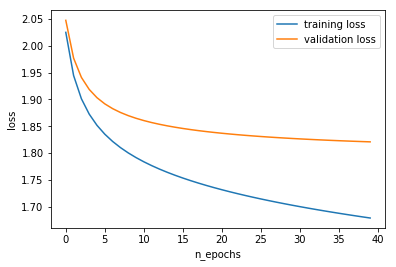

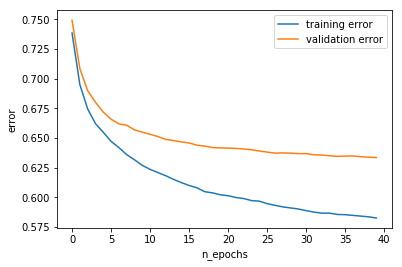

The accuracy on test set:  36.89 %


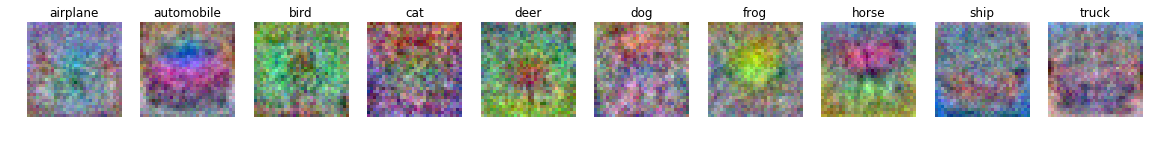

In [20]:
# Plot loss function
lamb = 0
GDparams = Parameter(100,0.01,40)
name_par = '1'

W_star,b_star = miniBatchGD(X,Y,y,GDparams,W,b,lamb,name_par)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star)*100,'%')

plotW(W_star,class_name,name_par)

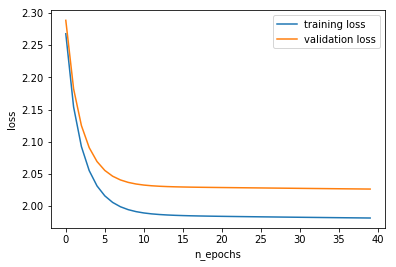

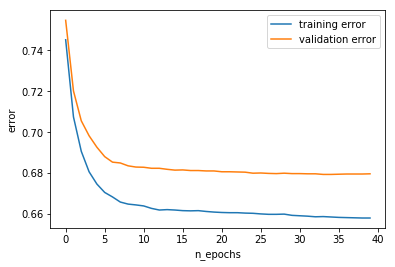

The accuracy on test set:  33.37 %


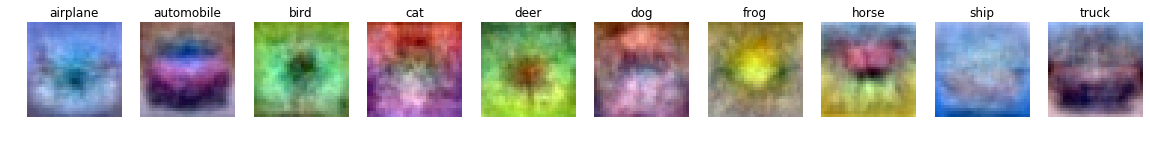

In [21]:
# Plot loss function
lamb = 0.1
GDparams = Parameter(100,0.01,40)
name_par = '2'

W_star,b_star = miniBatchGD(X,Y,y,GDparams,W,b,lamb,name_par)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star)*100,'%')

plotW(W_star,class_name,name_par)

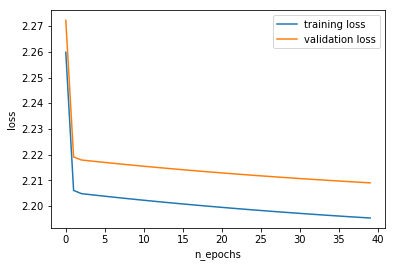

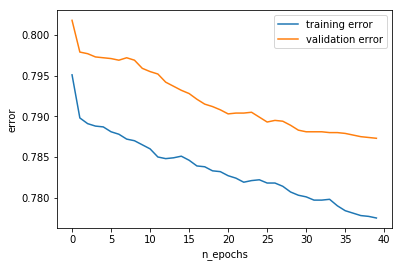

The accuracy on test set:  21.9 %


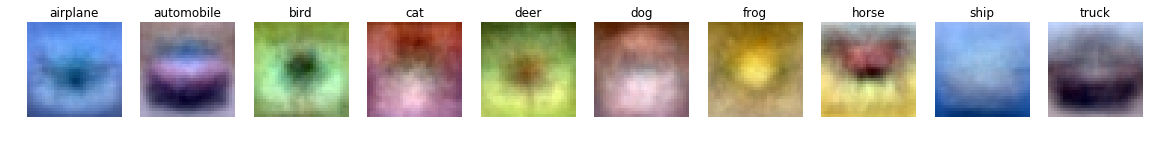

In [22]:
# Plot loss function
lamb = 1
GDparams = Parameter(100,0.01,40)
name_par = '3'

W_star,b_star = miniBatchGD(X,Y,y,GDparams,W,b,lamb,name_par)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star)*100,'%')

plotW(W_star,class_name,name_par)

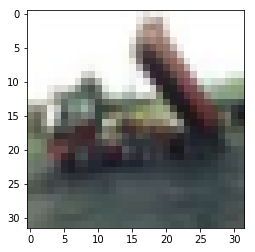

In [129]:
XTr,YTr,yTr = loadBatch('cifar-10-batches-py/data_batch_1')  # Training set
plt.imshow(XTr[:,2].reshape(3,32,32).transpose(1,2,0))
plt.show()